In [1]:
import astropy.constants as c
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import os
import re
# import h5py
# from astropy.convolution import convolve, Box1DKernel
from collections import defaultdict
# import matplotlib.pyplot as plt
import matplotlib
import scipy as sp
import scipy.interpolate

matplotlib.rcParams.update({'font.size': 12})

colorList = {'polarStatic':'tab:blue', 'polarDynamic':'k', 'noPolar':'tab:red', 'nothing':'tab:purple'}
colorAlias = {'JH_color':'Time-averaged [J-H] color', 'JK_color':r'Time-averaged [J-K$_s$] color', 'silicateIndex':'Si-index'}
markers = ['s', '^', '+']
aliasList = {'polarStatic':'Evolving Vortex', 'polarDynamic':'k', 'noPolar':'Stationary Vortex', 'nothing':'No Vortex'}


In [2]:
### ========= function to print levels of nested dicts =================
def print_nested_dict(d, indent=0):
    for key, value in d.items():
        print("  " * indent + str(key) + ":")
        if isinstance(value, dict):
            print_nested_dict(value, indent + 1)
        else:
            print("  " * (indent + 1) + str(value))

### ========= lamda function to create nested_dict ======================
def nested_dict():
    return defaultdict(nested_dict)

### ========= function to bring array value to one ======================
def bring_to_one(array):
    shift = (array.max() + array.min())/2
    return 1 + array - shift

### ========= itertools to generated random marker =====================
import itertools
markerRandomList = itertools.cycle((',', '+', '.', 'o', '*'))
linestyleRandomList = itertools.cycle(('--', '-', '-.', ':', ''))
### Usage
# for n in y:
#     plt.plot(x,n, marker = next(marker), linestyle='')

### =========  Function to do log-log interpolation =====================
def log_interp1d(xx, yy, kind='linear'):
    logx = np.log10(xx)
    logy = np.log10(yy)
    lin_interp = sp.interpolate.interp1d(logx, logy, kind=kind)
    log_interp = lambda zz: np.power(10.0, lin_interp(np.log10(zz)))
    return log_interp

### =========  Path to save plot figures ================================
plotPath = '/Users/nguyendat/Documents/GitHub/polar_vortice/PolarVortice/AtmopsherePlotterOutputPlots/'

In [5]:
productionKey = 'production1_phaseRandomized'

keys = ['10hr', '60hr']
amplitude1, amplitude2 = nested_dict(), nested_dict()
empty = []

for timeKey in keys:
    
    amplitudesDirectory = "/Users/nguyendat/Documents/GitHub/polar_vortice/PolarVortice/output/outputAmplitudes/"
    filename = '[%s]amplitudes[production1_phaseRandomized][0-60-60].pkl'%timeKey
    outputFilename = amplitudesDirectory+filename

    with open(outputFilename, 'rb') as f:
        dict1 = pickle.load(f)
    empty.append(dict1)
amplitude1, amplitude2 = empty[0], empty[1]

In [11]:
len(amplitude1['nothing'])

10

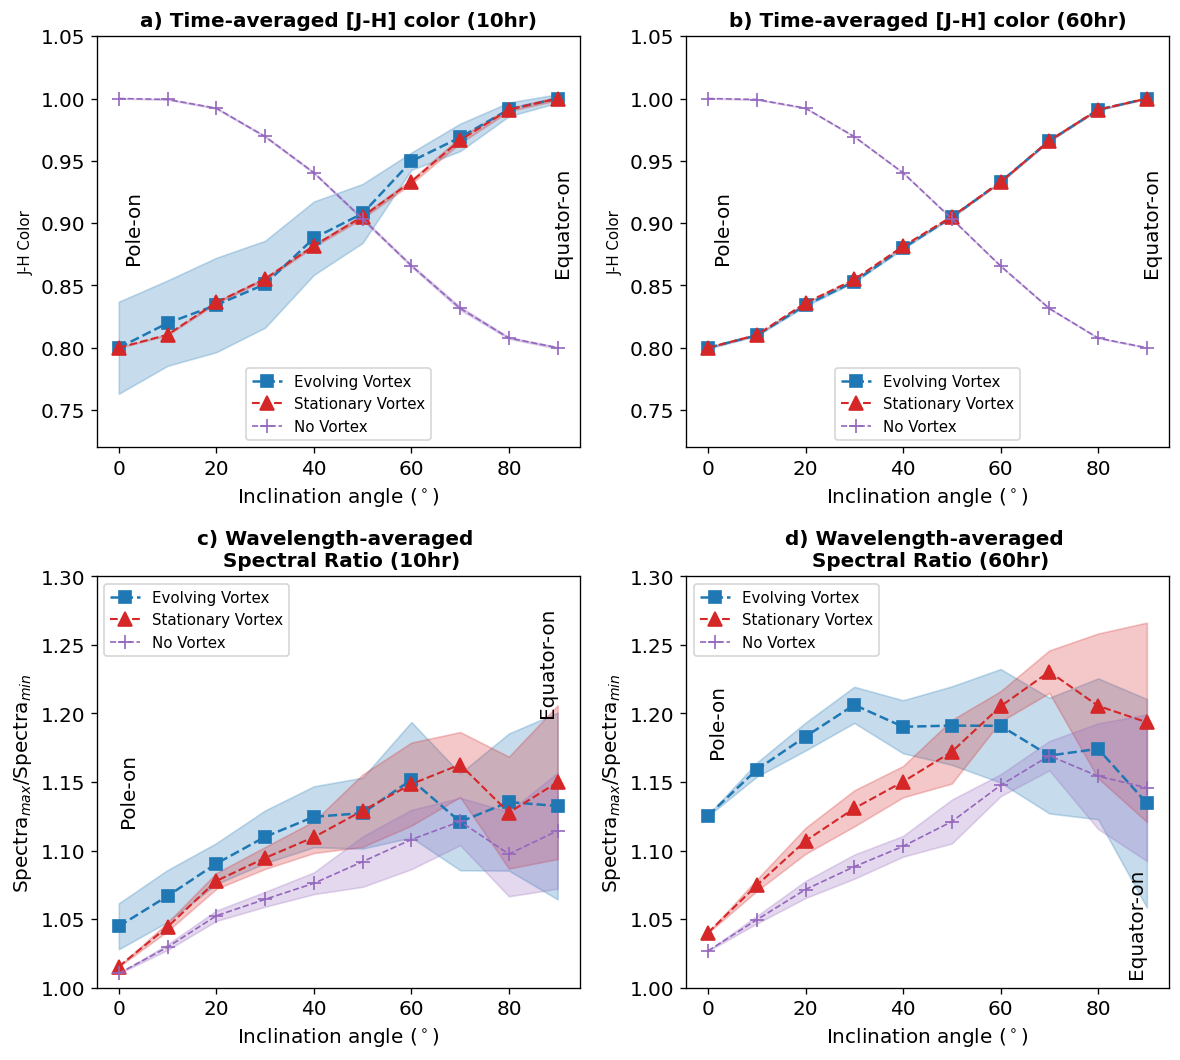

In [53]:
# ==========================================================
## Averaging over all the randPhase config and return mean trendline
# ==========================================================

# save = True
save = False

x_inclination = amplitude1['noPolar'][0]['flux'][:,0]
amplitudes_avg1 = nested_dict()
amplitudes_avg2 = nested_dict()

# ======= amplitude1 ==========
for model in ['polarStatic', 'noPolar', 'nothing']:
    for typename in ['JH_color', 'JK_color', 'flux', 'specRatio']:
        yavg, ymin, ymax = [], [], []
        for i, x in enumerate(x_inclination):
            yrange = []
            for counter in range(len(amplitude1['nothing'])):
                value = amplitude1[model][counter][typename][i,1]
                yrange.append(value)
            
            yavg.append([x, np.mean(yrange)])
            ymax.append([x, np.mean(yrange) + np.std(yrange)])
            ymin.append([x, np.mean(yrange) - np.std(yrange)])
            
        amplitudes_avg1[model][typename]['avg'] = np.array(yavg)
        amplitudes_avg1[model][typename]['max'] = np.array(ymax)
        amplitudes_avg1[model][typename]['min'] = np.array(ymin)
    
# ======= amplitude2 ==========
for model in ['polarStatic', 'noPolar', 'nothing']:
    for typename in ['JH_color', 'JK_color', 'flux', 'specRatio']:
        yavg, ymin, ymax = [], [], []
        for i, x in enumerate(x_inclination):
            yrange = []
            for counter in range(len(amplitude2['nothing'])):
                value = amplitude2[model][counter][typename][i,1]
                yrange.append(value)
            
            yavg.append([x, np.mean(yrange)])
            ymax.append([x, np.mean(yrange) + np.std(yrange)])
            ymin.append([x, np.mean(yrange) - np.std(yrange)])
            
        amplitudes_avg2[model][typename]['avg'] = np.array(yavg)
        amplitudes_avg2[model][typename]['max'] = np.array(ymax)
        amplitudes_avg2[model][typename]['min'] = np.array(ymin)
    
#### Plot 2x2 observables with inclinations
fig, axs = plt.subplots(2, 2, figsize=(10, 9), dpi=120)
plt.rcParams.update({'font.size': 12})
markers = ['s', '^', '+']
lsizes = [1.5, 1.25, 1]
offset_list = [0, 0, 0.]
line = '--'
msizes = [7,8,8]

# ==================== amplitude1 =============================
for i, model in enumerate(['polarStatic', 'noPolar', 'nothing']):
    
    JHcolor_avg = amplitudes_avg1[model]['JH_color']['avg'][:,1]
    JHcolor_min = amplitudes_avg1[model]['JH_color']['min'][:,1]
    JHcolor_max = amplitudes_avg1[model]['JH_color']['max'][:,1]

    specRatio_avg = amplitudes_avg1[model]['specRatio']['avg'][:,1]
    specRatio_min = amplitudes_avg1[model]['specRatio']['min'][:,1]
    specRatio_max = amplitudes_avg1[model]['specRatio']['max'][:,1]
    
    ### JHcolor + rescaling
    scale, offset = np.linalg.solve(b=(0.8, 1.0), a=((np.min(JHcolor_avg), 1), (np.max(JHcolor_avg), 1)))
    axs[0,0].plot(x_inclination+90, JHcolor_avg*scale + offset, ls=line, 
                  lw=lsizes[i], marker=markers[i], c=colorList[model], ms=msizes[i], label=aliasList[model])
    axs[0,0].fill_between(x_inclination+90, JHcolor_max*scale + offset, JHcolor_min*scale + offset,
                          color=colorList[model], alpha = 0.25)
    
    ### spectral ratio
    axs[1,0].plot(x_inclination+90, specRatio_avg, ls=line, lw=lsizes[i], 
                  marker=markers[i], c=colorList[model], ms=msizes[i], label=aliasList[model])               
    axs[1,0].fill_between(x_inclination+90, specRatio_max, specRatio_min, color=colorList[model], alpha = 0.25)


# ==================== amplitude2 =============================

for i, model in enumerate(['polarStatic', 'noPolar', 'nothing']):
    
    JHcolor_avg = amplitudes_avg2[model]['JH_color']['avg'][:,1]
    JHcolor_min = amplitudes_avg2[model]['JH_color']['min'][:,1]
    JHcolor_max = amplitudes_avg2[model]['JH_color']['max'][:,1]
    
    specRatio_avg = amplitudes_avg2[model]['specRatio']['avg'][:,1]
    specRatio_min = amplitudes_avg2[model]['specRatio']['min'][:,1]
    specRatio_max = amplitudes_avg2[model]['specRatio']['max'][:,1]
    
    ### JHcolor + rescaling
    scale, offset = np.linalg.solve(b=(0.8, 1.0), a=((np.min(JHcolor_avg), 1), (np.max(JHcolor_avg), 1)))
    axs[0,1].plot(x_inclination+90, JHcolor_avg*scale + offset, ls=line, 
                  lw=lsizes[i], marker=markers[i], c=colorList[model], ms=msizes[i], label=aliasList[model])
    axs[0,1].fill_between(x_inclination+90, JHcolor_max*scale + offset, JHcolor_min*scale + offset,
                          color=colorList[model], alpha = 0.25)

    ### spectral ratio
    axs[1,1].plot(x_inclination+90, specRatio_avg, ls=line, lw=lsizes[i], 
                  marker=markers[i], c=colorList[model], ms=msizes[i], label=aliasList[model])               
    axs[1,1].fill_between(x_inclination+90, specRatio_max, specRatio_min, color=colorList[model], alpha = 0.25)
    
#### formatting
fonttitle = 12
fontnormal = 9
fontsuptitle = 12

lims = [([0.72, 1.05], [0.72, 1.05]), 
        ([1, 1.3], [1, 1.3])]
for m in range(2):
    for n in range(2):
        axs[m,n].legend(loc='lower center', fontsize=fontnormal)
        axs[m,n].set_xlabel(r'Inclination angle ($^\circ$)', fontsize=fonttitle)
        axs[m,n].set_ylim(lims[m][n])
        # axs[m,m].set_xticklabels(fontsize=fontnormal)

axs[0,0].set_ylabel(r'J-H Color', fontsize=fontnormal)
axs[0,1].set_ylabel(r'J-H Color', fontsize=fontnormal)
    
# fig.suptitle('Long-duration Monitoring: 60hr Data', fontsize=fontsuptitle)
axs[1,0].legend(loc='upper left', fontsize=fontnormal)
axs[1,1].legend(loc='upper left', fontsize=fontnormal)

# if t1==5: titleAdd = '[5hr]'
# elif t1==10: titleAdd = '[10hr]'

axs[0,0].set_title('a) '+colorAlias['JH_color']+' (%s)'%keys[0], fontsize=fonttitle, weight='bold')
axs[0,1].set_title('b) '+colorAlias['JH_color']+' (%s)'%keys[1], fontsize=fonttitle, weight='bold')
    
axs[1,0].set_ylabel(r'Spectra$_{max}$/Spectra$_{min}$', fontsize=fonttitle)
axs[1,1].set_ylabel(r'Spectra$_{max}$/Spectra$_{min}$', fontsize=fonttitle)

axs[1,0].set_title('c) '+'Wavelength-averaged \n Spectral Ratio (%s)'%keys[0], fontsize=fonttitle, weight='bold')
axs[1,1].set_title('d) '+'Wavelength-averaged \n Spectral Ratio (%s)'%keys[1], fontsize=fonttitle, weight='bold')

axs[0,0].text(1, 0.87, 'Pole-on', rotation='vertical'), axs[0,0].text(89, 0.86, 'Equator-on', rotation='vertical')
axs[0,1].text(1, 0.87, 'Pole-on', rotation='vertical'), axs[0,1].text(89, 0.86, 'Equator-on', rotation='vertical')

axs[1,0].text(0, 1.12, 'Pole-on', rotation='vertical'), axs[1,0].text(86, 1.20, 'Equator-on', rotation='vertical')
axs[1,1].text(0, 1.17, 'Pole-on', rotation='vertical'), axs[1,1].text(86, 1.01, 'Equator-on', rotation='vertical')

plt.tight_layout()

if save:
    plotOut = plotPath + '/2x2[phasesRandomized]nonFit_observables_inclinationTrend'
    plt.savefig(plotOut+'.pdf', dpi=300, format='pdf', bbox_inches = 'tight')
    plt.savefig(plotOut+'.png', dpi=300, format='png', bbox_inches = 'tight')